# Cartpole Problem

# Importing Modules

In [69]:
import gym 
import torch
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output
from torch.autograd import Variable
import numpy as np

# Environment Testing with Random Variables

In [70]:
env_name = 'CartPole-v1'
env= gym.make(env_name)

In [71]:
env.action_space.sample() #action_space has 2 values: 0 & 1. sample gives value 0/1 randomly

0

# Model Building

In [72]:
class DQL():
        ''' Deep Q-Learning Neural Network class. '''
        def __init__(self, state_dim, action_dim, hidden_dim, lr):
                self.criterion = torch.nn.MSELoss()
                self.model = torch.nn.Sequential(
                                torch.nn.Linear(state_dim, hidden_dim),
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(hidden_dim, hidden_dim*2),
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(hidden_dim*2, action_dim)
                                )
                self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        def update(self, state, y):
                """Update the weights of the network given a training sample. """
                y_pred = self.model(torch.Tensor(state))
                loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        def predict(self, state):
                """ Compute Q values for all actions using the DQL. """
                with torch.no_grad():
                        return self.model(torch.Tensor(state))
        def replay(self, memory, size, gamma=0.9):
                if len(memory)>=size:
                        batch = random.sample(memory,size)
                        batch_t = list(map(list, zip(*batch))) #Transpose batch list
                        states = batch_t[0]
                        actions = batch_t[1]
                        next_states = batch_t[2]
                        rewards = batch_t[3]
                        is_dones = batch_t[4]
                        
                        states = torch.Tensor(np.array(states))
                        actions_tensor = torch.Tensor(np.array(actions))
                        next_states = torch.Tensor(np.array(next_states))
                        rewards = torch.Tensor(np.array(rewards))
                        is_dones_tensor = torch.Tensor(np.array(is_dones))
                        
                        is_dones_indices = torch.where(is_dones_tensor==True)[0]

                        all_q_values = self.model(states) # predicted q_values of all states
                        all_q_values_next = self.model(next_states)
                        #Update q values
                        all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
                        all_q_values[is_dones_indices.tolist(), np.array(actions_tensor[is_dones]).astype(int).tolist()]=rewards[is_dones_indices.tolist()]
                        
                        
                        self.update(states.tolist(), all_q_values.tolist())

# Module to Plot the Reward Variation with each episode

In [73]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(475, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(475, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

# Random Strategy

In [76]:
def random_search(env, episodes, 
                  title='Random Strategy'):
    """ Random search strategy implementation."""
    final = []
    episode_i = 0
    for episode in range(episodes):
        state = env.reset()
        done = False
        total = 0
        episode_i += 1
        while not done:
            env.render()
            # Sample random actions
            action = env.action_space.sample()
            # Take action and extract results
            next_state, reward, done, _ = env.step(action)
            # Update reward
            total += reward
            if done:
                break
        # Add to the final reward
        final.append(total)
        plot_res(final,title)
        print("episode: {}, total reward: {}".format(episode_i, total))

    return final

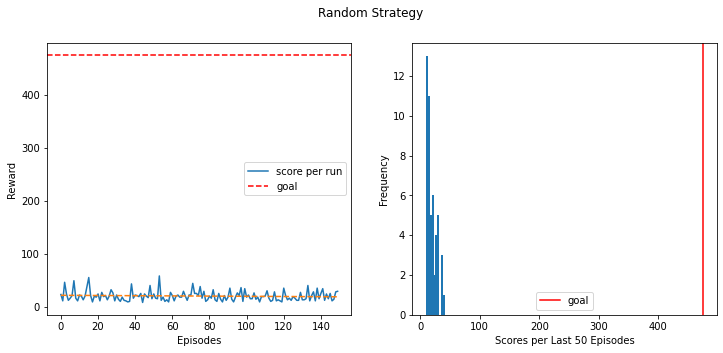

episode: 150, total reward: 30.0


In [77]:
# Get random search results
random_s = random_search(env, 150)

# Model Training

In [ ]:
def q_learning(env, model, episodes, gamma, epsilon, eps_decay=0.99,replay=False, replay_size=20, title = 'DQL'):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    episode_i = 0
    for episode in range(episodes):
        # Reset state
        state = env.reset()
        done = False
        total = 0
        episode_i += 1 
        while not done:
            env.render()
            # Implement greedy search policy
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)
            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)
        print("episode: {}, total reward: {}".format(episode_i, total))
    env.close()
    return final

# Model Testing

In [ ]:
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 150
# Number of hidden nodes in the DQN
n_hidden = 64
# Learning rate
lr = 0.001

In [ ]:
dqn = DQL(n_state, n_action, n_hidden, lr)
replay = q_learning(env, dqn, 
                    episodes, gamma=.9, 
                    epsilon=0.2,replay = True,
                    title='DQL with Replay')

error: display Surface quit